            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849


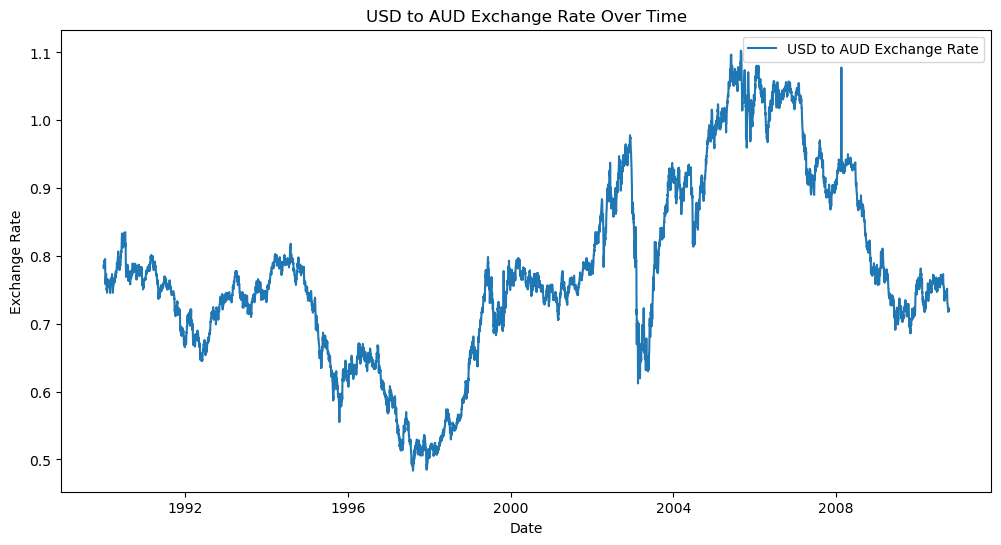

Missing values: 0


In [13]:
# ==========================
# Part 1: Data Preparation and Exploration
# ==========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# --------------------------
# Step 1: Load dataset
# --------------------------
df = pd.read_csv("C:\\Users\\Sindu\\Desktop\\Assignment ExcelR\\Timeseries\\Timeseries\\exchange_rate.csv")

# Convert date column properly (dayfirst = True for DD-MM-YYYY format)
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.set_index('date', inplace=True)

# Rename for convenience
series = df['Ex_rate']

# Preview dataset
print(df.head())

# --------------------------
# Step 2: Initial Exploration
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(series, label="USD to AUD Exchange Rate")
plt.title("USD to AUD Exchange Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

# --------------------------
# Step 3: Check Missing Values
# --------------------------
print("Missing values:", series.isnull().sum())
series = series.fillna(method='ffill')


ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974
Series is non-stationary, differencing may be required.


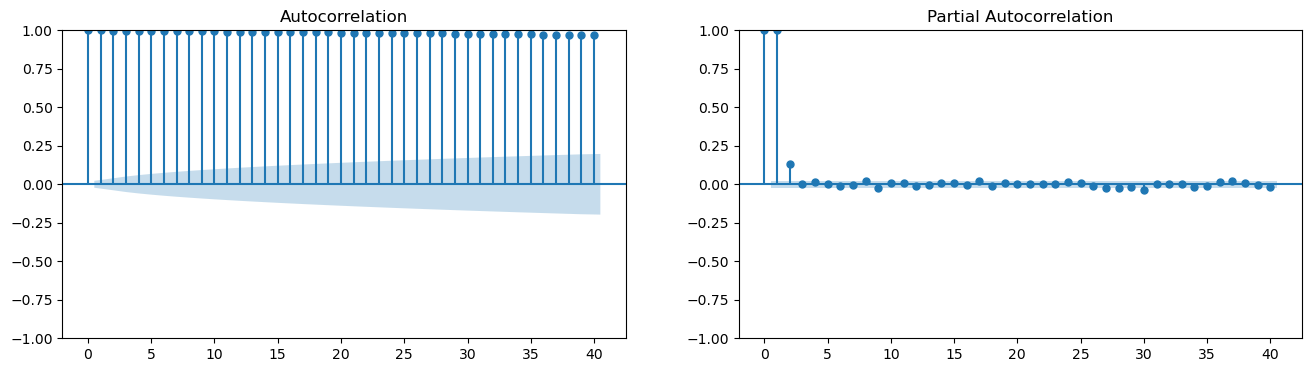

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Mon, 18 Aug 2025   AIC                         -45432.092
Time:                        13:07:22   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

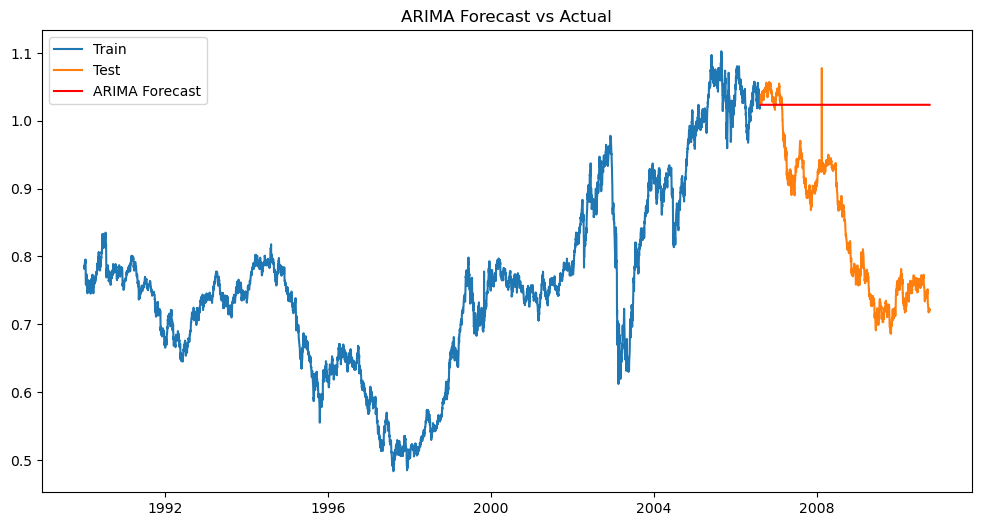

In [15]:
# ==========================
# Part 2: ARIMA Model
# ==========================

# Step 1: Stationarity check
result = adfuller(series)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Series is non-stationary, differencing may be required.")
else:
    print("Series is stationary.")

# Step 2: Plot ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(16,4))
plot_acf(series, ax=axes[0], lags=40)
plot_pacf(series, ax=axes[1], lags=40, method='ywm')
plt.show()

# Step 3: Train-test split
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Step 4: Fit ARIMA model (start with 1,1,1; can tune later)
model_arima = ARIMA(train, order=(1,1,1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

# Step 5: Forecast
forecast_arima = model_arima_fit.forecast(steps=len(test))

plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()


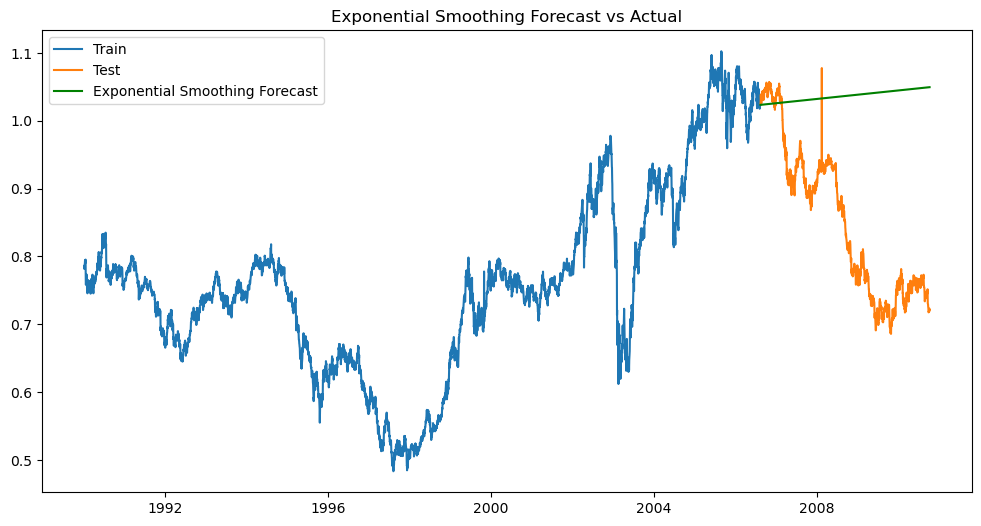

In [17]:
# ==========================
# Part 3: Exponential Smoothing
# ==========================

# Step 1: Fit Holt’s Linear Trend Method
model_es = ExponentialSmoothing(train, trend="add", seasonal=None)
model_es_fit = model_es.fit(optimized=True)

# Step 2: Forecast
forecast_es = model_es_fit.forecast(len(test))

plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, forecast_es, label="Exponential Smoothing Forecast", color="green")
plt.title("Exponential Smoothing Forecast vs Actual")
plt.legend()
plt.show()


In [19]:
# ==========================
# Part 4: Evaluation & Comparison
# ==========================

def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# ARIMA metrics
mae_arima, rmse_arima, mape_arima = evaluate_forecast(test, forecast_arima)

# Exponential Smoothing metrics
mae_es, rmse_es, mape_es = evaluate_forecast(test, forecast_es)

print("\nModel Performance Comparison:")
print("ARIMA -> MAE={:.4f}, RMSE={:.4f}, MAPE={:.2f}%".format(mae_arima, rmse_arima, mape_arima))
print("Exponential Smoothing -> MAE={:.4f}, RMSE={:.4f}, MAPE={:.2f}%".format(mae_es, rmse_es, mape_es))

if rmse_arima < rmse_es:
    print("\nConclusion: ARIMA performed better.")
else:
    print("\nConclusion: Exponential Smoothing performed better.")



Model Performance Comparison:
ARIMA -> MAE=0.1777, RMSE=0.2054, MAPE=22.80%
Exponential Smoothing -> MAE=0.1903, RMSE=0.2201, MAPE=24.41%

Conclusion: ARIMA performed better.
